In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG'

Mounted at /content/gdrive
/content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG


In [2]:
pip install tensorflow

In [3]:
import os
import cv2
import numpy as np
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Keras and TensorFlow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


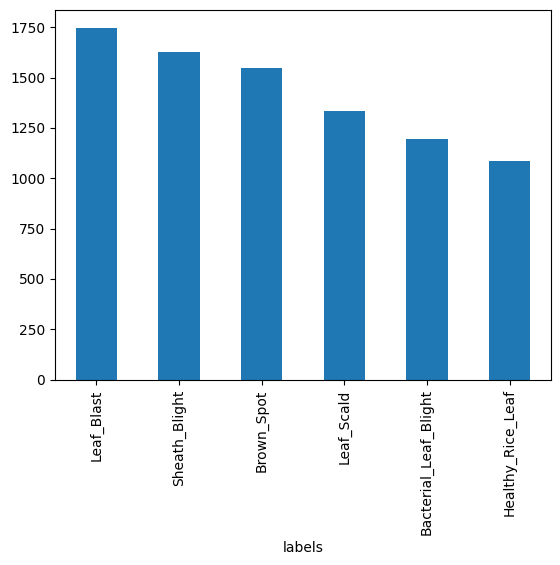

labels
Leaf_Blast               1748
Sheath_Blight            1629
Brown_Spot               1546
Leaf_Scald               1332
Bacterial_Leaf_Blight    1197
Healthy_Rice_Leaf        1085
Name: count, dtype: int64


In [4]:
# class list
classes = ["Sheath_Blight", "Leaf_Blast", "Leaf_Scald",
           "Brown_Spot", "Bacterial_Leaf_Blight", "Healthy_Rice_Leaf"]

labels = []
image_links = []
class_path ='/content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG'
# load and label emages
for class_name in classes:
    images = glob.glob(f'{class_path}/{class_name}/*.jpg')
    labels.extend([class_name] * len(images))
    image_links.extend(images)
# transfer data to dataframe
data = pd.DataFrame({'labels': labels, 'image_links': image_links})

# check the number of images per layer
data['labels'].value_counts().plot.bar()
plt.show()
print(data['labels'].value_counts())


In [5]:
# split the test set (15%)
images_train_val, images_test, y_train_val, y_test = train_test_split(
    image_links, labels, stratify=labels, test_size=0.15, random_state=42)

print(f'Train + Val: {len(images_train_val)}, Test: {len(images_test)}')

 # split train and validation from the train_val set
images_train, images_val, y_train, y_val = train_test_split(
    images_train_val, y_train_val, stratify=y_train_val, test_size=0.176, random_state=42) # 0.176 * 85% = 15%

print(f'Train: {len(images_train)}, Val: {len(images_val)}, Test: {len(images_test)}')


Train + Val: 7256, Test: 1281
Train: 5978, Val: 1278, Test: 1281


In [6]:
# load and resize emages function
def load_and_resize_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error reading image: {img_path}")
        return None
    img_resized = cv2.resize(img, target_size)  # Resize emages
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)  # Đổi sang RGB (OpenCV đọc theo BGR)
    img_normalized = img_rgb / 255.0
    return img_normalized
# check emages size
for img_path in image_links:
    img = load_and_resize_image(img_path)
    if img is not None:
        # print proccessed emages
        print(f"Processed image shape for {img_path}: {img.shape}")
        if img.shape != (224, 224, 3):
            print(f"Unexpected shape for {img_path}: {img.shape}")


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Processed image shape for /content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG/Leaf_Scald/aug_0_3114.jpg: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG/Leaf_Scald/aug_0_3230.jpg: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG/Leaf_Scald/aug_0_3323.jpg: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG/Leaf_Scald/aug_0_3145.jpg: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG/Leaf_Scald/aug_0_3199.jpg: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG/Leaf_Scald/aug_0_3154.jpg: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG/Leaf_Scald/aug_0_3128.jpg: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG/Leaf_Sca

In [7]:
# initialize ImageDataGenerator for
# train set with data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# validation set (no augmentation)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# test set (no augmentation)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# create label encoder
encoder = LabelEncoder()

# transfer label to
# numeric for train and validation dataset
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

# one-hot for train and validation dataset
y_train_onehot = to_categorical(y_train_encoded, num_classes=6)
y_val_onehot = to_categorical(y_val_encoded, num_classes=6)

# numeric for test set
y_test_encoded = encoder.transform(y_test)
# Create generators
# for train set
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_links': images_train, 'labels': y_train}),
    x_col='image_links',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# for validation set
val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_links': images_val, 'labels': y_val}),
    x_col='image_links',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# for test set
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_links': images_test, 'labels': y_test}),
    x_col='image_links',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    # the order for evaluation
    shuffle=False
)



Found 5978 validated image filenames belonging to 6 classes.
Found 1278 validated image filenames belonging to 6 classes.
Found 1281 validated image filenames belonging to 6 classes.


In [8]:
# check images size in train set
for i in range(6):
    img = load_and_resize_image(images_train[i])
    if img is not None:
        print(f"Image {i} shape: {img.shape}")
batch_images, batch_labels = next(train_generator)
print(f'Batch image shape: {batch_images.shape}')
print(f'Batch label shape: {batch_labels.shape}')

Image 0 shape: (224, 224, 3)
Image 1 shape: (224, 224, 3)
Image 2 shape: (224, 224, 3)
Image 3 shape: (224, 224, 3)
Image 4 shape: (224, 224, 3)
Image 5 shape: (224, 224, 3)
Batch image shape: (32, 224, 224, 3)
Batch label shape: (32, 6)


In [9]:
# create base model with DenseNet121
base_network = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Set the initial layers of DenseNet121 to be untrainable
for layer in base_network.layers:
  # Freeze classes
    layer.trainable = False

# build model
model = Sequential([
    base_network,
    GlobalAveragePooling2D(),              # Global Average Pooling
    Dropout(0.5),                          # Dropout to reduce overfitting
    Dense(64, activation='relu'),          # Hidden layer
    BatchNormalization(),                  # BatchNormalization to optimize
    Dropout(0.5),                          # Dropout again
    Dense(6, activation='softmax')         # Output layer = 6
])

# Compile model with optimizer
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
# build model and show information
model.build((None, 224, 224, 3))
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,103,750 (27.10 MB)

 Trainable params: 66,118 (258.27 KB)

 Non-trainable params: 7,037,632 (26.85 MB)

In [10]:
model.fit(train_generator, epochs=5, validation_data=val_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 1405s 7s/step - accuracy: 0.3043 - loss: 2.2220 - val_accuracy: 0.6706 - val_loss: 0.9059
Epoch 2/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 1397s 7s/step - accuracy: 0.5228 - loss: 1.2901 - val_accuracy: 0.7066 - val_loss: 0.7971
Epoch 3/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 1411s 8s/step - accuracy: 0.5699 - loss: 1.1604 - val_accuracy: 0.7293 - val_loss: 0.7335
Epoch 4/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 1431s 8s/step - accuracy: 0.5888 - loss: 1.1109 - val_accuracy: 0.7480 - val_loss: 0.7133
Epoch 5/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 1441s 8s/step - accuracy: 0.6059 - loss: 1.0582 - val_accuracy: 0.7543 - val_loss: 0.6925


In [11]:
# Unlock the last 10 layers
for layer in base_network.layers[-10:]:
    layer.trainable = True

# Recompile the model with a smaller Learning Rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # ussing smaller learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

# fine-tune training
history_fine_tune = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1487s 8s/step - accuracy: 0.6299 - loss: 1.0063 - val_accuracy: 0.7660 - val_loss: 0.6480 - learning_rate: 1.0000e-04
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1438s 8s/step - accuracy: 0.6419 - loss: 0.9725 - val_accuracy: 0.7746 - val_loss: 0.6013 - learning_rate: 1.0000e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1471s 8s/step - accuracy: 0.6659 - loss: 0.9125 - val_accuracy: 0.7919 - val_loss: 0.5703 - learning_rate: 1.0000e-04
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1462s 8s/step - accuracy: 0.6893 - loss: 0.8583 - val_accuracy: 0.8067 - val_loss: 0.5327 - learning_rate: 1.0000e-04
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1431s 8s/step - accuracy: 0.6973 - loss: 0.8186 - val_accuracy: 0.8122 - val_loss: 0.4949 - learning_rate: 1.0000e-04
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1422s 8s/step - accuracy: 0.7327 - loss: 0.7516 - val_accuracy: 0.8318 - val_loss: 0.4526 - learning_rate: 1.0000e-04
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1485s 8s/ste

In [12]:
# Save in native Keras format
model.save('DenseNet121.keras')

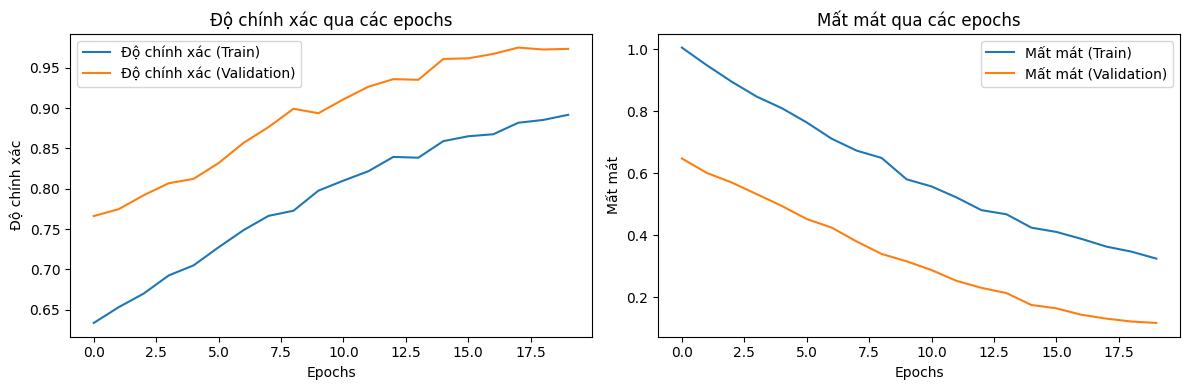

In [13]:
# # Plot accuracy graph
plt.figure(figsize=(12, 4))

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(history_fine_tune.history['accuracy'], label='Độ chính xác (Train)')
plt.plot(history_fine_tune.history['val_accuracy'], label='Độ chính xác (Validation)')
plt.title('Độ chính xác qua các epochs')
plt.xlabel('Epochs')
plt.ylabel('Độ chính xác')
plt.legend()

# Loss graph
plt.subplot(1, 2, 2)
plt.plot(history_fine_tune.history['loss'], label='Mất mát (Train)')
plt.plot(history_fine_tune.history['val_loss'], label='Mất mát (Validation)')
plt.title('Mất mát qua các epochs')
plt.xlabel('Epochs')
plt.ylabel('Mất mát')
plt.legend()

plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG/performance_tracking_chart_DenseNet121ver5.png')
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 254s 6s/step
Accuracy: 0.9719
Precision: 0.9724
Recall: 0.9719
F1-Score: 0.9719


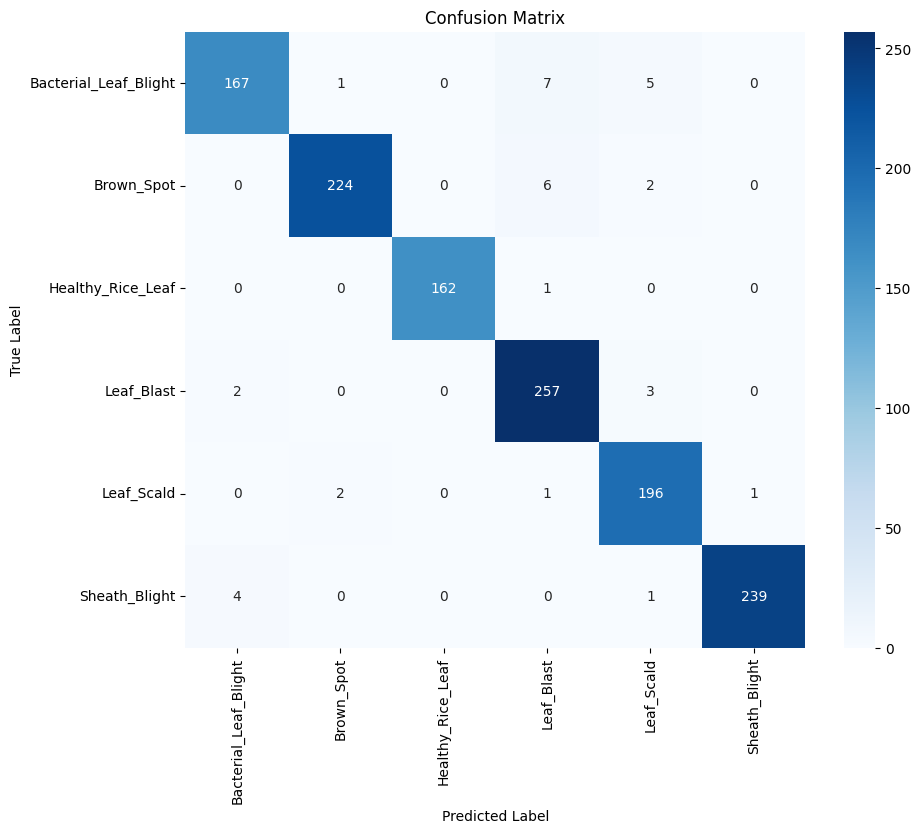


Classification Report:
                       precision    recall  f1-score   support

Bacterial_Leaf_Blight       0.97      0.93      0.95       180
           Brown_Spot       0.99      0.97      0.98       232
    Healthy_Rice_Leaf       1.00      0.99      1.00       163
           Leaf_Blast       0.94      0.98      0.96       262
           Leaf_Scald       0.95      0.98      0.96       200
        Sheath_Blight       1.00      0.98      0.99       244

             accuracy                           0.97      1281
            macro avg       0.97      0.97      0.97      1281
         weighted avg       0.97      0.97      0.97      1281



In [14]:
# predict in test set
# Ensure correct order of data
test_generator.reset()
y_pred = model.predict(test_generator)
# Select the class with the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the actual labels from the test set
y_true = test_generator.classes

# Calculate the indexes
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# print results
print(f"Accuracy: {round(accuracy,4)}")
print(f"Precision: {round(precision,4)}")
print(f"Recall: {round(recall,4)}")
print(f"F1-Score: {round(f1,4)}")

# print Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# save Confusion Matrix emage
plt.savefig("confusion_matrix_DenseNet121ver5.png", dpi=300, bbox_inches='tight')
plt.show()

# print Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


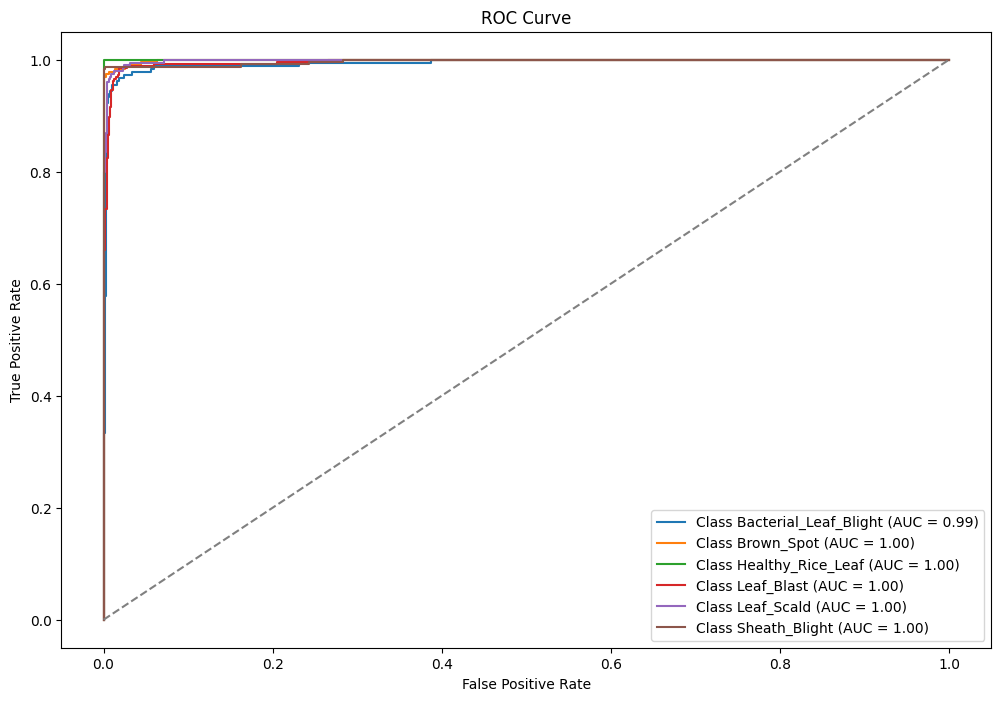

In [15]:
# transfer y_true to binary format
n_classes = len(test_generator.class_indices)
y_true_binary = label_binarize(y_true, classes=range(n_classes))

# draw ROC
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {list(test_generator.class_indices.keys())[i]} (AUC = {roc_auc:.2f})")

# Draw diagonal lines
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# Chart Format
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

# save chart to image file
plt.savefig("roc_auc_curve_DenseNet121ver5.png", dpi=300, bbox_inches='tight')
plt.show()
